In [1]:
# import modules
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import osmnx as ox
import pandas as pd

# Read data 

In [2]:
# read data on trees and bike paths
treesGdf = gpd.read_file('data/trees_delft.shp')
bikeGraph = ox.io.load_graphml('data/bikePaths.graphml')
bikeGdfs = ox.utils_graph.graph_to_gdfs(bikeGraph)
bikeNodes = bikeGdfs[0]
bikeEdges = bikeGdfs[1]

# Make shadows

In [51]:
# input
treePct = 50 # % tree cover to be considered as shadows
bufferM = 20 # m for buffer to create shadow

# find shadows created by trees
trees = treesGdf[treesGdf.trees > treePct]
treesBuffer = trees.geometry.buffer(bufferM).unary_union
shadows = treesBuffer # multipolygon
shadowsGdf = gpd.GeoDataFrame(treesBuffer).rename(columns={0:'geometry'}).reset_index()
shadowsPlot = shadowsGdf.copy()
shadowsPlot = shadowsPlot.set_crs('EPSG:28992').to_crs('EPSG:4326')

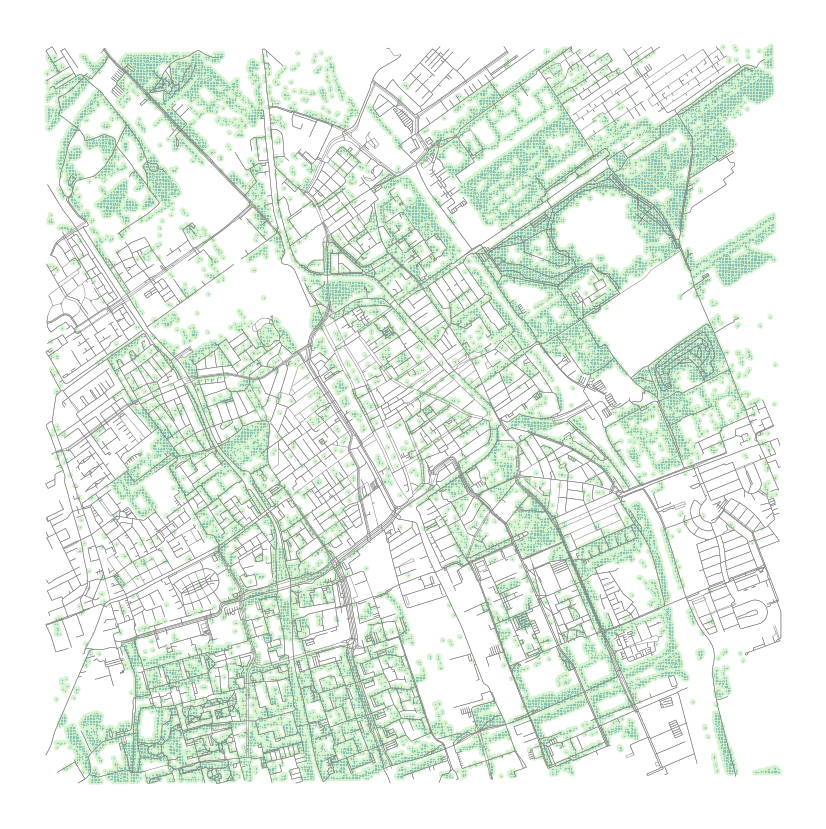

In [4]:
fig, ax = plt.subplots(figsize=(15,15))
trees.to_crs('EPSG:4326').plot(ax=ax, markersize=0.1)
shadowsPlot.plot(ax=ax, fc='#b2e8a0', alpha=0.5, zorder=1)
bikeEdges.plot(ax=ax, color='grey', linewidth=0.5)
ax.axis('off')
plt.show()

# Find shaded bike paths

In [172]:
# prepare elements for finding shaded bike paths 
bikeEdges_a = bikeEdges.to_crs('EPSG:28992').reset_index()
bikeNodes_a = bikeNodes.reset_index().to_crs('EPSG:28992')
shadows_cut = ox.utils_geo._quadrat_cut_geometry(shadows, quadrat_width=1000)
sindex = bikeEdges_a.sindex # build the r-tree index

# find shadedEdges and shadedNodes
points_within_geometry = pd.DataFrame()
for poly in shadows_cut.geoms:
    possible_matches_index = list(sindex.intersection(poly.bounds))
    possible_matches = bikeEdges_a.iloc[possible_matches_index]
    precise_matches = possible_matches[possible_matches.intersects(poly)]
    points_within_geometry = pd.concat([points_within_geometry, precise_matches])
    
# output: bike paths and nodes that are shaded 
shadedEdges = points_within_geometry.copy()
shadedEdges.osmid = shadedEdges.osmid.map(lambda x: tuple(x) if isinstance(x, list) else x)
shadedEdges = shadedEdges.drop_duplicates(subset='osmid')
shadedNodeIds = list(shadedEdges.u) + list(shadedEdges.v)
shadedNodes = bikeNodes_a[bikeNodes_a.osmid.isin(shadedNodeIds)]

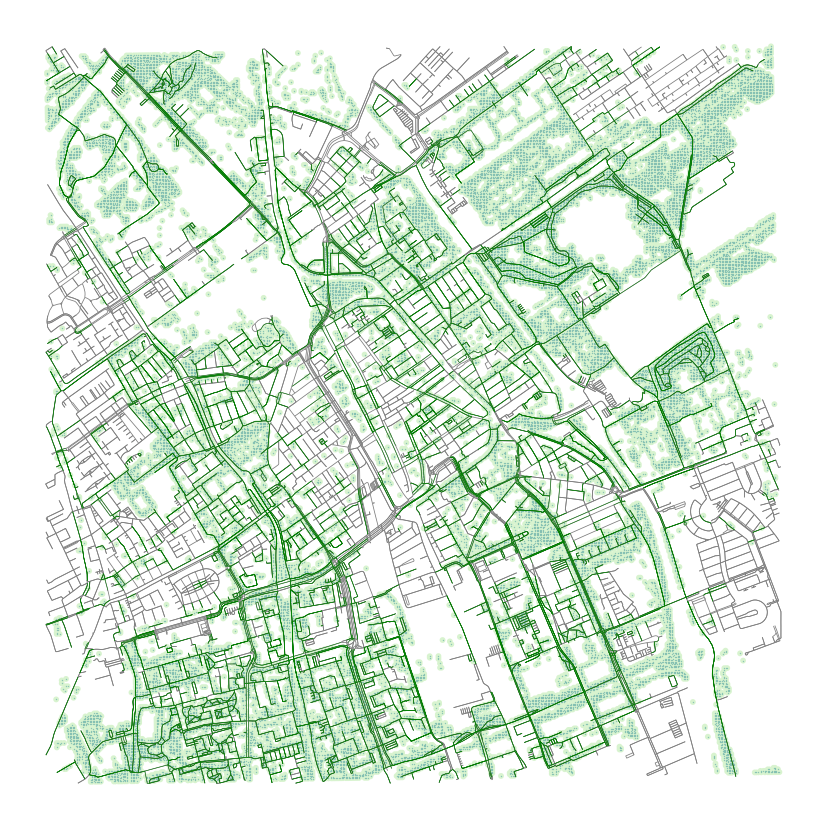

In [80]:
fig, ax = plt.subplots(figsize=(15,15))
trees.to_crs('EPSG:4326').plot(ax=ax, markersize=0.1)
shadowsPlot.plot(ax=ax, fc='#b2e8a0', alpha=0.5, zorder=1)
bikeEdges.plot(ax=ax, color='grey', linewidth=0.8)
shadedEdges.to_crs('EPSG:4326').plot(ax=ax, color='green', linewidth=0.5)
ax.axis('off')
plt.show()

# Find shortest path

In [6]:
# input
origAddress = 'Papenstraat 71, 2611 JB Delft'
destAddress = 'Prometheusplein 1, 2628 ZC Delft'

# geocode orgin and destination address 
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="shadyStreets")
origLoc = geolocator.geocode(origAddress)
destLoc = geolocator.geocode(destAddress)

# covert bike path gdfs to graph
shadedNodes_g = shadedNodes.to_crs('EPSG:4326').set_index('osmid')
shadedEdges_g = shadedEdges.to_crs('EPSG:4326').set_index(['u', 'v', 'key'])
G_shaded = ox.utils_graph.graph_from_gdfs(shadedNodes_g, shadedEdges_g, graph_attrs=None)

# impute missing edge speeds and calculate edge travel times with the speed module
G_shaded = ox.speed.add_edge_speeds(G_shaded)
G_shaded = ox.speed.add_edge_travel_times(G_shaded)

# convert to strongly connected graph
Gs = ox.utils_graph.get_largest_component(G_shaded, strongly=True)
orig = ox.distance.nearest_nodes(Gs, X=origLoc.longitude, Y=origLoc.latitude)
dest = ox.distance.nearest_nodes(Gs, X=destLoc.longitude, Y=destLoc.latitude)

# output: shortest shaded route
route_shaded = ox.shortest_path(Gs, orig, dest, weight="travel_time")

C:\Users\tpytsui\Miniconda\envs\geo_env\lib\site-packages\osmnx\utils_graph.py:155: UserWarning: discarding the gdf_nodes geometry column, though its values differ from the coordinates in the x and y columns
  warnings.warn(


In [7]:
shadowsPlot = shadowsGdf.copy()
shadowsPlot = shadowsPlot.set_crs('EPSG:28992')
shadowsPlot = shadowsPlot.to_crs('EPSG:4326')

# Plot showing different bike paths

In [8]:
# show which streets were cut from coversion to strongly connected network 
shadedGdfs = ox.utils_graph.graph_to_gdfs(Gs)
shadedNodes_s = shadedGdfs[0] # s for 'strong', as in strongly connected graph
shadedEdges_s = shadedGdfs[1]

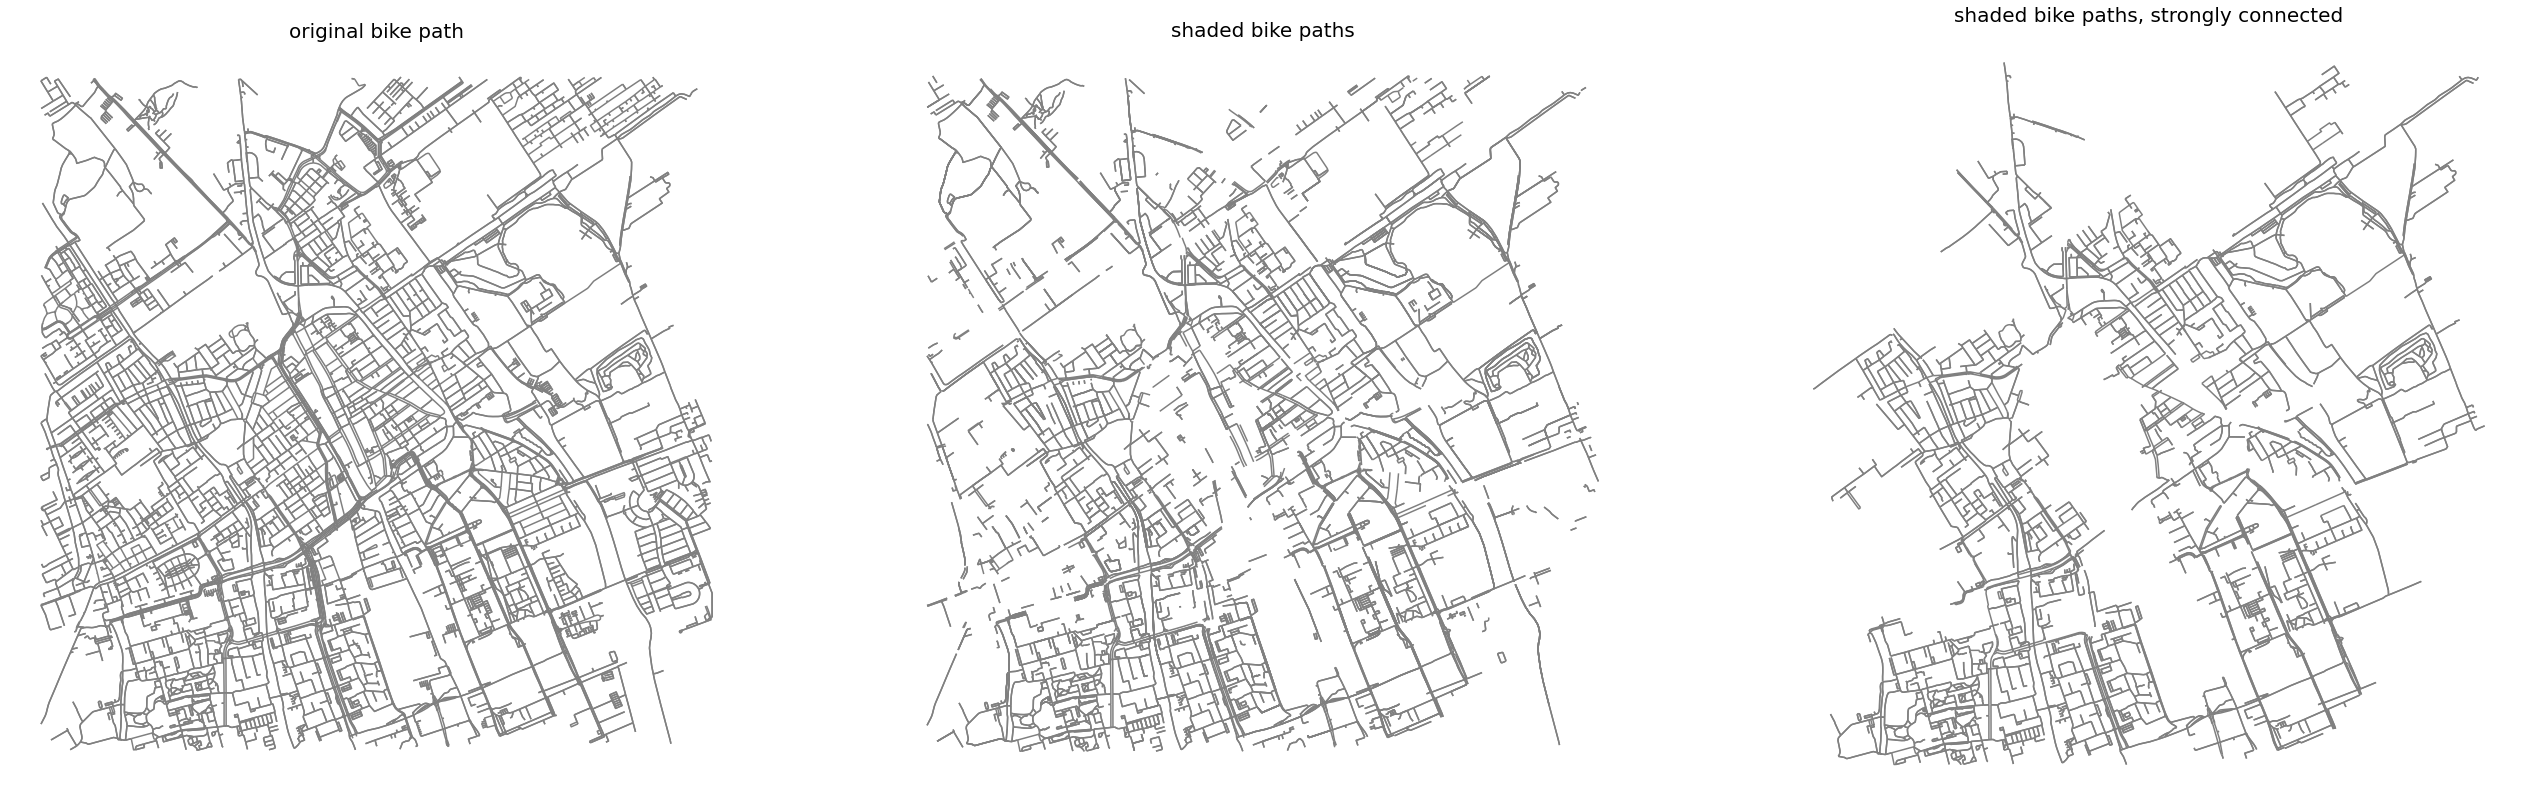

In [107]:
fig, ax = plt.subplots(1, 3, figsize=(15*3,15))
bikeEdges.plot(ax=ax[0], color='grey')
shadedEdges.to_crs('EPSG:4326').plot(ax=ax[1], color='grey')
shadedEdges_s.plot(ax=ax[2], color='grey')
for i, title in enumerate(['original bike path', 'shaded bike paths', 'shaded bike paths, strongly connected']): 
    ax[i].axis('off')
    ax[i].set_title(title, fontsize=20)
plt.show()

# Final plot

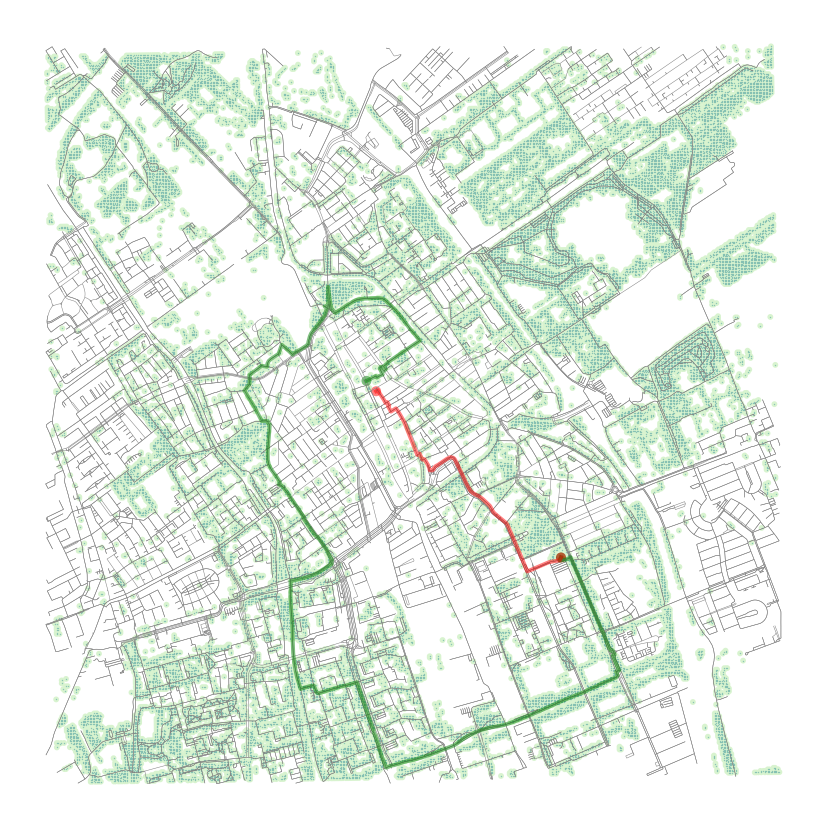

In [9]:
# input
plotNormal = True

# calculate normal (unshaded) path
if plotNormal == True: 
    # calculate normal path route
    bikeGraph = ox.speed.add_edge_speeds(bikeGraph)
    bikeGraph = ox.speed.add_edge_travel_times(bikeGraph)

    # get the nearest network nodes to two lat/lng points with the distance module
    orig = ox.distance.nearest_nodes(bikeGraph, X=origLoc.longitude, Y=origLoc.latitude)
    dest = ox.distance.nearest_nodes(bikeGraph, X=destLoc.longitude, Y=destLoc.latitude)
    route_normal = ox.shortest_path(bikeGraph, orig, dest, weight="travel_time")

# plot routes
fig, ax = plt.subplots(figsize=(15, 15))
ax.axis('off')
trees.to_crs('EPSG:4326').plot(ax=ax, markersize=0.1)
bikeEdges.plot(ax=ax, color='grey', linewidth=0.5)
shadowsPlot.plot(ax=ax, fc='#b2e8a0', alpha=0.5, zorder=1)
if plotNormal == True: 
    ox.plot.plot_graph_routes(bikeGraph, [route_shaded, route_normal], route_colors=['g', 'r'], ax=ax)
else: 
    ox.plot_graph_route(Gs, route_shaded, node_size=0, ax=ax, route_color='b')
plt.show()

# Find streets most in need of shade

In [125]:
row = shadedEdges.iloc[0]
gpd.GeoDataFrame(row).T.set_crs('EPSG:28992')

u           v key      osmid name  highway oneway   length  \
8015  1516978033  1516977986   0  138360215  NaN  service  False  143.697   

     bridge width                                           geometry maxspeed  \
8015    NaN   NaN  LINESTRING (82188.249 445122.836, 82062.662 44...      NaN   

     service lanes access tunnel  ref junction est_width  
8015     NaN   NaN    NaN    NaN  NaN      NaN       NaN

In [219]:
def calcShadedPc(row): 
    # find which shadow overlaps with edge 
    spatial_index = shadowsGdf.sindex # gdf = shadows 
    possible_matches_index = list(spatial_index.intersection(row.geometry.bounds)) # polygon = edge
    possible_matches = shadowsGdf.iloc[possible_matches_index]
    shadow_matches = possible_matches[possible_matches.intersects(row.geometry)].set_crs('EPSG:28992')
    
    # calculate % of edge inside shadow
    testEdge = gpd.GeoDataFrame(row).T.set_crs('EPSG:28992')
    testEdge_shaded = gpd.overlay(shadow_matches, testEdge, how='intersection', keep_geom_type=False)
    lenShaded = testEdge_shaded.length.sum()
    lenTotal = testEdge.length.sum()
    pcShaded = round(lenShaded/lenTotal*100)
    
    return pcShaded

In [222]:
%%time
shadedEdges['treeCoverPerc'] = shadedEdges.apply(lambda row: calcShadedPc(row), axis=1)

CPU times: total: 4min 23s
Wall time: 4min 42s


In [223]:
shadedEdges

u           v  key                   osmid              name  \
8015   1516978033  1516977986    0               138360215               NaN   
8003   1516977922  1516978033    0               138360242               NaN   
14085  7035449381  1516977956    0  (138360195, 526453179)     Kerkpolderweg   
8006   1516977956  7035449381    0  (526453179, 138360195)     Kerkpolderweg   
8014   1516978003  1516977956    0               207493698      Kooislootpad   
...           ...         ...  ...                     ...               ...   
1819     44841041    44841599    0                 7537118       Swanecampen   
10886  3544048252   310776739    0               348248812               NaN   
5258    916681127   310776739    0                42114940  Delftsestraatweg   
3679    310776735  8828046219    0               146543424  Delftsestraatweg   
4461    526316580  1258783245    0               437654618           Hazepad   

            highway  oneway   length bridge width  \
8015        service   False  143.697    NaN   NaN   
8003        service   False  136.089    NaN   NaN   
14085  unclassified   False  163.609    NaN   NaN   
8006   unclassified   False  163.609    NaN   NaN   
8014       cycleway   False  291.037    NaN   NaN   
...             ...     ...      ...    ...   ...   
1819       cycleway   False   81.494    NaN   NaN   
10886       service   False   42.023    NaN   NaN   
5258       tertiary   False   29.667    NaN   NaN   
3679       cycleway   False   72.058    NaN   NaN   
4461       cycleway   False   43.769    NaN   2.5   

                                                geometry  maxspeed  \
8015   LINESTRING (82188.249 445122.836, 82062.662 44...       NaN   
8003   LINESTRING (82256.034 445004.633, 82252.215 44...       NaN   
14085  LINESTRING (82305.011 445185.839, 82293.360 44...  [60, 30]   
8006   LINESTRING (82283.919 445033.880, 82290.906 44...  [60, 30]   
8014   LINESTRING (82566.017 445057.162, 82536.544 44...       NaN   
...                                                  ...       ...   
1819   LINESTRING (86936.153 447240.296, 86940.521 44...       NaN   
10886  LINESTRING (86929.891 447298.142, 86950.339 44...       NaN   
5258   LINESTRING (86921.854 447306.942, 86925.293 44...        30   
3679   LINESTRING (86913.424 447311.675, 86917.374 44...       NaN   
4461   LINESTRING (86973.642 449863.532, 86981.097 44...       NaN   

             service lanes access tunnel  ref junction est_width  \
8015             NaN   NaN    NaN    NaN  NaN      NaN       NaN   
8003             NaN   NaN    NaN    NaN  NaN      NaN       NaN   
14085            NaN   NaN    NaN    NaN  NaN      NaN       NaN   
8006             NaN   NaN    NaN    NaN  NaN      NaN       NaN   
8014             NaN   NaN    NaN    NaN  NaN      NaN       NaN   
...              ...   ...    ...    ...  ...      ...       ...   
1819             NaN   NaN    NaN    NaN  NaN      NaN       NaN   
10886  parking_aisle   NaN    NaN    NaN  NaN      NaN       NaN   
5258             NaN     2    NaN    NaN  NaN      NaN       NaN   
3679             NaN   NaN    NaN    NaN  NaN      NaN       NaN   
4461             NaN   NaN    NaN    NaN  NaN      NaN       NaN   

       treeCoverPerc  
8015              59  
8003              42  
14085             90  
8006              90  
8014              90  
...              ...  
1819              75  
10886             75  
5258              33  
3679              21  
4461              60  

[3460 rows x 20 columns]

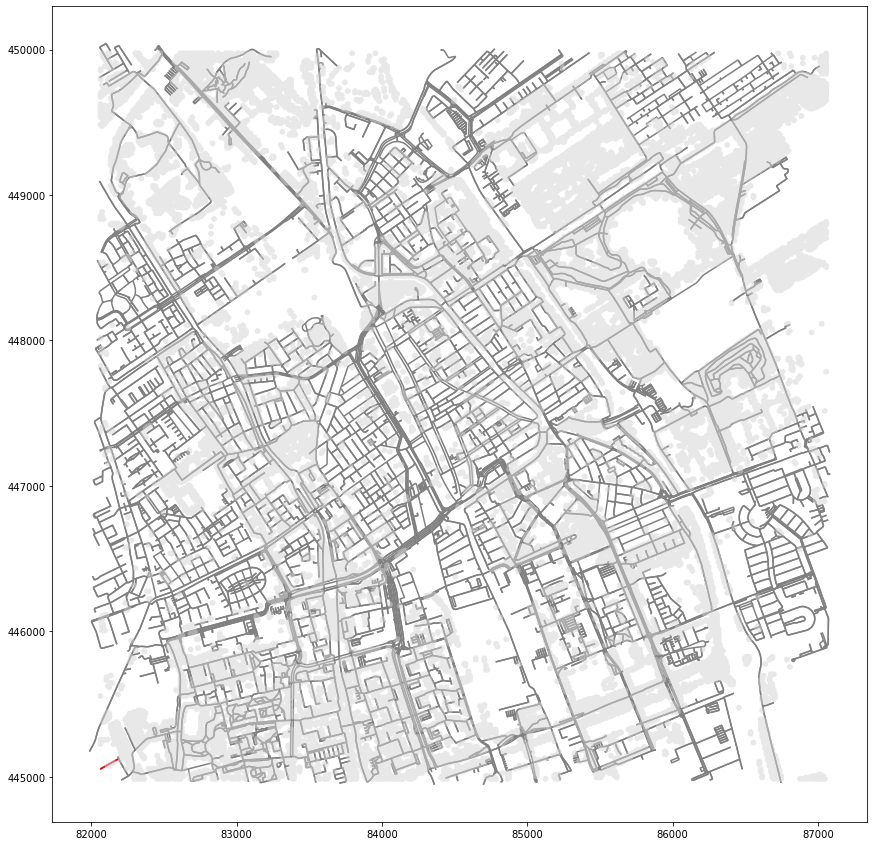

In [32]:
# calculate % tree coverage for each bike edge
testEdge = shadedEdges.iloc[[0]]
fig, ax = plt.subplots(figsize=(15,15))
bikeEdges_a.plot(ax=ax, color='grey')
shadowsGdf.plot(ax=ax, color='lightgrey', alpha=0.5, zorder=3)
testEdge.plot(ax=ax, color='red', zorder=2)
plt.show()

In [ ]:
# adjust shadows with better thresholds 

# for each bike edge, calculate % tree coverage 

# for each bike edge, claculate accessibility (centrality)

# scatter plot of bike edges on accessibility vs tree coverage 

# identify edges with high acceessibility and low tree coverage 

# plot results